In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ==========================================
# BLACK-SCHOLES MODEL
# ==========================================

class BlackScholesModel:
    """Black-Scholes option pricing model implementation"""
    
    def __init__(self, S, K, T, r, sigma):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
    
    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_price(self):
        d1_val = self.d1()
        d2_val = self.d2()
        call = self.S * norm.cdf(d1_val) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2_val)
        return call
    
    def put_price(self):
        d1_val = self.d1()
        d2_val = self.d2()
        put = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2_val) - self.S * norm.cdf(-d1_val)
        return put
    
    def greeks(self):
        d1_val = self.d1()
        d2_val = self.d2()
        
        # Delta
        call_delta = norm.cdf(d1_val)
        put_delta = call_delta - 1
        
        # Gamma
        gamma = norm.pdf(d1_val) / (self.S * self.sigma * np.sqrt(self.T))
        
        # Theta
        call_theta = (-self.S * norm.pdf(d1_val) * self.sigma / (2 * np.sqrt(self.T)) - 
                     self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2_val)) / 365
        
        put_theta = (-self.S * norm.pdf(d1_val) * self.sigma / (2 * np.sqrt(self.T)) + 
                    self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2_val)) / 365
        
        # Vega
        vega = self.S * norm.pdf(d1_val) * np.sqrt(self.T) / 100
        
        # Rho
        call_rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2_val) / 100
        put_rho = -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2_val) / 100
        
        return {
            'call_delta': call_delta, 'put_delta': put_delta, 'gamma': gamma,
            'call_theta': call_theta, 'put_theta': put_theta, 'vega': vega,
            'call_rho': call_rho, 'put_rho': put_rho
        }


In [4]:
# ==========================================
# BINOMIAL MODEL
# ==========================================

class BinomialModel:
    """Binomial tree option pricing model"""
    
    def __init__(self, S, K, T, r, sigma, n=100):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n = n
        
        # Calculate tree parameters
        self.dt = T / n
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)
        self.discount = np.exp(-r * self.dt)
    
    def call_price(self):
        # Initialize asset prices at maturity
        asset_prices = np.zeros(self.n + 1)
        for i in range(self.n + 1):
            asset_prices[i] = self.S * (self.u ** (self.n - i)) * (self.d ** i)
        
        # Initialize option values at maturity
        option_values = np.maximum(asset_prices - self.K, 0)
        
        # Work backwards through the tree
        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                option_values[i] = self.discount * (
                    self.p * option_values[i] + (1 - self.p) * option_values[i + 1]
                )
        
        return option_values[0]
    
    def put_price(self):
        # Initialize asset prices at maturity
        asset_prices = np.zeros(self.n + 1)
        for i in range(self.n + 1):
            asset_prices[i] = self.S * (self.u ** (self.n - i)) * (self.d ** i)
        
        # Initialize option values at maturity
        option_values = np.maximum(self.K - asset_prices, 0)
        
        # Work backwards through the tree
        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                option_values[i] = self.discount * (
                    self.p * option_values[i] + (1 - self.p) * option_values[i + 1]
                )
        
        return option_values[0]


In [5]:
# ==========================================
# MONTE CARLO MODEL
# ==========================================

class MonteCarloModel:
    """Monte Carlo simulation for option pricing"""
    
    def __init__(self, S, K, T, r, sigma, n_simulations=10000):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_simulations = n_simulations
    
    def call_price(self):
        # Generate random stock price paths
        np.random.seed(42)  # For reproducible results
        Z = np.random.normal(0, 1, self.n_simulations)
        
        # Calculate final stock prices using geometric Brownian motion
        ST = self.S * np.exp((self.r - 0.5 * self.sigma**2) * self.T + 
                            self.sigma * np.sqrt(self.T) * Z)
        
        # Calculate payoffs
        payoffs = np.maximum(ST - self.K, 0)
        
        # Discount back to present value
        option_price = np.exp(-self.r * self.T) * np.mean(payoffs)
        standard_error = np.std(payoffs) / np.sqrt(self.n_simulations)
        
        return option_price, standard_error
    
    def put_price(self):
        # Generate random stock price paths
        np.random.seed(42)  # For reproducible results
        Z = np.random.normal(0, 1, self.n_simulations)
        
        # Calculate final stock prices
        ST = self.S * np.exp((self.r - 0.5 * self.sigma**2) * self.T + 
                            self.sigma * np.sqrt(self.T) * Z)
        
        # Calculate payoffs
        payoffs = np.maximum(self.K - ST, 0)
        
        # Discount back to present value
        option_price = np.exp(-self.r * self.T) * np.mean(payoffs)
        standard_error = np.std(payoffs) / np.sqrt(self.n_simulations)
        
        return option_price, standard_error
    
    def get_convergence_data(self, max_sims=5000, step=100):
        """Analyze Monte Carlo convergence"""
        convergence_data = []
        np.random.seed(42)
        
        for n_sim in range(step, max_sims + 1, step):
            Z = np.random.normal(0, 1, n_sim)
            ST = self.S * np.exp((self.r - 0.5 * self.sigma**2) * self.T + 
                                self.sigma * np.sqrt(self.T) * Z)
            payoffs = np.maximum(ST - self.K, 0)
            option_price = np.exp(-self.r * self.T) * np.mean(payoffs)
            convergence_data.append(option_price)
        
        return convergence_data


OPTION PRICING MODELS AND THEIR ACCURACY

Example Parameters:
Current Stock Price (S): $100
Strike Price (K): $105
Time to Expiration: 30 days
Risk-free Rate: 5.0%
Volatility: 20.0%

CHECKPOINT 3: BLACK-SCHOLES MODEL
Black-Scholes Call Price: $0.7308
Black-Scholes Put Price: $5.3002

Greeks:
Call Delta: 0.2265
Put Delta: -0.7735
Gamma: 0.0525
Call Theta: -0.0318
Put Theta: -0.0174
Vega: 0.0863
Call Rho: 0.0180
Put Rho: -0.0679

CHECKPOINT 2: BINOMIAL MODEL
Binomial Call Price: $0.7316
Binomial Put Price: $5.3010

CHECKPOINT 4: MONTE CARLO SIMULATIONS
Monte Carlo Call Price: $0.7363 (±0.0199)
Monte Carlo Put Price: $5.3168 (±0.0464)

MODEL COMPARISON
           Model  Call Price  Put Price  Call Diff from BS  Put Diff from BS
0  Black-Scholes      0.7308     5.3002             0.0000            0.0000
1       Binomial      0.7316     5.3010             0.0008            0.0008
2    Monte Carlo      0.7363     5.3168             0.0055            0.0166

CHECKPOINT 5: BACKTESTING SIMULAT

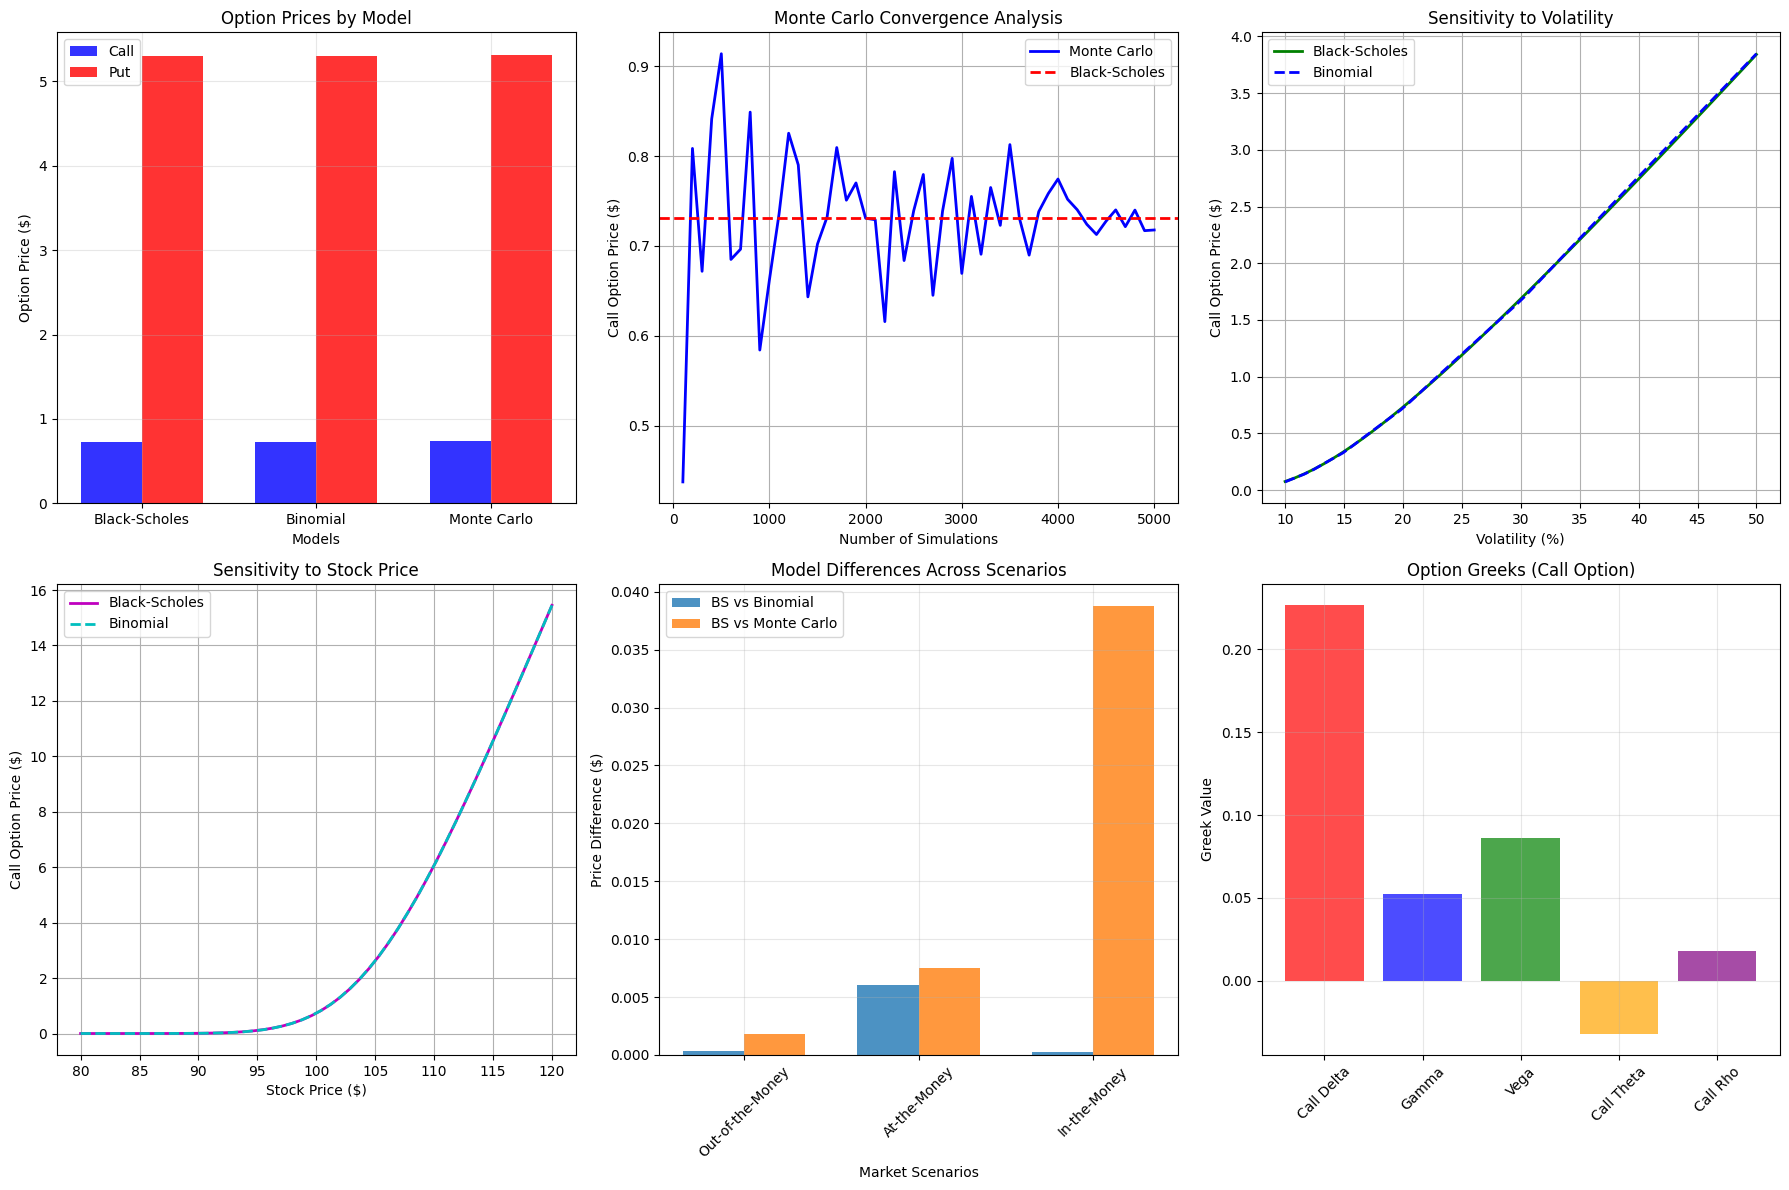


CHECKPOINT 6: ACCURACY ANALYSIS SUMMARY

    OPTION PRICING MODELS ACCURACY ANALYSIS
    
    Model Comparison Results:
    - Black-Scholes Call: $0.7308
    - Binomial Call:      $0.7316 (Diff: $0.0008)
    - Monte Carlo Call:   $0.7363 (Diff: $0.0055)
    
    Key Findings:
    1. Binomial model converges to Black-Scholes as steps increase
    2. Monte Carlo provides probabilistic estimates with confidence intervals
    3. All methods show close agreement for standard European options
    4. Differences mainly due to discretization and sampling errors
    
    Accuracy Assessment:
    - Binomial vs Black-Scholes: 0.11% difference
    - Monte Carlo vs Black-Scholes: 0.76% difference
    
    Conclusion:
    All three models demonstrate high accuracy for European option pricing.
    The choice of model depends on specific requirements:
    - Black-Scholes: Fastest, analytical solution
    - Binomial: Flexible for American options
    - Monte Carlo: Best for complex payoffs and risk an

In [6]:
# ==========================================
# MAIN ANALYSIS
# ==========================================

def main():
    """Main execution function for Option Pricing Models and Accuracy Analysis"""
    
    print("=" * 70)
    print("OPTION PRICING MODELS AND THEIR ACCURACY")
    print("=" * 70)
    
    # Example parameters
    S = 100      # Current stock price
    K = 105      # Strike price
    T = 30/365   # Time to expiration (30 days)
    r = 0.05     # Risk-free rate (5%)
    sigma = 0.2  # Volatility (20%)
    
    print(f"\nExample Parameters:")
    print(f"Current Stock Price (S): ${S}")
    print(f"Strike Price (K): ${K}")
    print(f"Time to Expiration: {30} days")
    print(f"Risk-free Rate: {r*100}%")
    print(f"Volatility: {sigma*100}%")
    
    # ==========================================
    # CHECKPOINT 3: BLACK-SCHOLES MODEL
    # ==========================================
    
    print("\n" + "="*70)
    print("CHECKPOINT 3: BLACK-SCHOLES MODEL")
    print("="*70)
    
    bs_model = BlackScholesModel(S, K, T, r, sigma)
    bs_call = bs_model.call_price()
    bs_put = bs_model.put_price()
    greeks = bs_model.greeks()
    
    print(f"Black-Scholes Call Price: ${bs_call:.4f}")
    print(f"Black-Scholes Put Price: ${bs_put:.4f}")
    
    print(f"\nGreeks:")
    print(f"Call Delta: {greeks['call_delta']:.4f}")
    print(f"Put Delta: {greeks['put_delta']:.4f}")
    print(f"Gamma: {greeks['gamma']:.4f}")
    print(f"Call Theta: {greeks['call_theta']:.4f}")
    print(f"Put Theta: {greeks['put_theta']:.4f}")
    print(f"Vega: {greeks['vega']:.4f}")
    print(f"Call Rho: {greeks['call_rho']:.4f}")
    print(f"Put Rho: {greeks['put_rho']:.4f}")
    
    # ==========================================
    # CHECKPOINT 2: BINOMIAL MODEL
    # ==========================================
    
    print("\n" + "="*70)
    print("CHECKPOINT 2: BINOMIAL MODEL")
    print("="*70)
    
    bin_model = BinomialModel(S, K, T, r, sigma, n=100)
    bin_call = bin_model.call_price()
    bin_put = bin_model.put_price()
    
    print(f"Binomial Call Price: ${bin_call:.4f}")
    print(f"Binomial Put Price: ${bin_put:.4f}")
    
    # ==========================================
    # CHECKPOINT 4: MONTE CARLO SIMULATIONS
    # ==========================================
    
    print("\n" + "="*70)
    print("CHECKPOINT 4: MONTE CARLO SIMULATIONS")
    print("="*70)
    
    mc_model = MonteCarloModel(S, K, T, r, sigma, n_simulations=10000)
    mc_call, mc_call_se = mc_model.call_price()
    mc_put, mc_put_se = mc_model.put_price()
    
    print(f"Monte Carlo Call Price: ${mc_call:.4f} (±{mc_call_se:.4f})")
    print(f"Monte Carlo Put Price: ${mc_put:.4f} (±{mc_put_se:.4f})")
    
    # ==========================================
    # MODEL COMPARISON
    # ==========================================
    
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'Model': ['Black-Scholes', 'Binomial', 'Monte Carlo'],
        'Call Price': [bs_call, bin_call, mc_call],
        'Put Price': [bs_put, bin_put, mc_put],
        'Call Diff from BS': [0, abs(bs_call - bin_call), abs(bs_call - mc_call)],
        'Put Diff from BS': [0, abs(bs_put - bin_put), abs(bs_put - mc_put)]
    })
    
    print(comparison_df.round(4))
    
    # ==========================================
    # CHECKPOINT 5: BACKTESTING SIMULATION
    # ==========================================
    
    print("\n" + "="*70)
    print("CHECKPOINT 5: BACKTESTING SIMULATION")
    print("="*70)
    
    # Simulate different market conditions
    scenarios = [
        {'S': 90, 'name': 'Out-of-the-Money'},
        {'S': 105, 'name': 'At-the-Money'},
        {'S': 120, 'name': 'In-the-Money'}
    ]
    
    backtest_results = []
    
    for scenario in scenarios:
        bs_test = BlackScholesModel(scenario['S'], K, T, r, sigma)
        bin_test = BinomialModel(scenario['S'], K, T, r, sigma, n=100)
        mc_test = MonteCarloModel(scenario['S'], K, T, r, sigma, n_simulations=5000)
        
        bs_call_test = bs_test.call_price()
        bin_call_test = bin_test.call_price()
        mc_call_test, _ = mc_test.call_price()
        
        backtest_results.append({
            'Scenario': scenario['name'],
            'Stock Price': scenario['S'],
            'BS Call': bs_call_test,
            'Binomial Call': bin_call_test,
            'MC Call': mc_call_test,
            'BS vs Binomial': abs(bs_call_test - bin_call_test),
            'BS vs MC': abs(bs_call_test - mc_call_test)
        })
    
    backtest_df = pd.DataFrame(backtest_results)
    print(backtest_df.round(4))
    
    # ==========================================
    # VISUALIZATIONS
    # ==========================================
    
    print("\n" + "="*70)
    print("CREATING VISUALIZATIONS...")
    print("="*70)
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Model Comparison
    models = ['Black-Scholes', 'Binomial', 'Monte Carlo']
    call_prices = [bs_call, bin_call, mc_call]
    put_prices = [bs_put, bin_put, mc_put]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, call_prices, width, label='Call', alpha=0.8, color='blue')
    axes[0, 0].bar(x + width/2, put_prices, width, label='Put', alpha=0.8, color='red')
    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Option Price ($)')
    axes[0, 0].set_title('Option Prices by Model')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Monte Carlo Convergence
    convergence_data = mc_model.get_convergence_data(max_sims=5000, step=100)
    sim_counts = range(100, 5001, 100)
    
    axes[0, 1].plot(sim_counts, convergence_data, 'b-', linewidth=2, label='Monte Carlo')
    axes[0, 1].axhline(y=bs_call, color='r', linestyle='--', linewidth=2, label='Black-Scholes')
    axes[0, 1].set_xlabel('Number of Simulations')
    axes[0, 1].set_ylabel('Call Option Price ($)')
    axes[0, 1].set_title('Monte Carlo Convergence Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot 3: Sensitivity to Volatility
    vol_range = np.linspace(0.1, 0.5, 50)
    bs_calls_vol = []
    bin_calls_vol = []
    
    for vol in vol_range:
        temp_bs = BlackScholesModel(S, K, T, r, vol)
        temp_bin = BinomialModel(S, K, T, r, vol, n=50)
        bs_calls_vol.append(temp_bs.call_price())
        bin_calls_vol.append(temp_bin.call_price())
    
    axes[0, 2].plot(vol_range * 100, bs_calls_vol, 'g-', linewidth=2, label='Black-Scholes')
    axes[0, 2].plot(vol_range * 100, bin_calls_vol, 'b--', linewidth=2, label='Binomial')
    axes[0, 2].set_xlabel('Volatility (%)')
    axes[0, 2].set_ylabel('Call Option Price ($)')
    axes[0, 2].set_title('Sensitivity to Volatility')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Plot 4: Sensitivity to Stock Price
    stock_range = np.linspace(80, 120, 50)
    bs_calls_stock = []
    bin_calls_stock = []
    
    for stock_price in stock_range:
        temp_bs = BlackScholesModel(stock_price, K, T, r, sigma)
        temp_bin = BinomialModel(stock_price, K, T, r, sigma, n=50)
        bs_calls_stock.append(temp_bs.call_price())
        bin_calls_stock.append(temp_bin.call_price())
    
    axes[1, 0].plot(stock_range, bs_calls_stock, 'm-', linewidth=2, label='Black-Scholes')
    axes[1, 0].plot(stock_range, bin_calls_stock, 'c--', linewidth=2, label='Binomial')
    axes[1, 0].set_xlabel('Stock Price ($)')
    axes[1, 0].set_ylabel('Call Option Price ($)')
    axes[1, 0].set_title('Sensitivity to Stock Price')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 5: Model Differences
    scenarios_names = [result['Scenario'] for result in backtest_results]
    bs_vs_bin_diffs = [result['BS vs Binomial'] for result in backtest_results]
    bs_vs_mc_diffs = [result['BS vs MC'] for result in backtest_results]
    
    x = np.arange(len(scenarios_names))
    axes[1, 1].bar(x - width/2, bs_vs_bin_diffs, width, label='BS vs Binomial', alpha=0.8)
    axes[1, 1].bar(x + width/2, bs_vs_mc_diffs, width, label='BS vs Monte Carlo', alpha=0.8)
    axes[1, 1].set_xlabel('Market Scenarios')
    axes[1, 1].set_ylabel('Price Difference ($)')
    axes[1, 1].set_title('Model Differences Across Scenarios')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(scenarios_names, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Greeks Visualization
    greeks_names = ['Call Delta', 'Gamma', 'Vega', 'Call Theta', 'Call Rho']
    greeks_values = [greeks['call_delta'], greeks['gamma'], greeks['vega'], 
                    greeks['call_theta'], greeks['call_rho']]
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    axes[1, 2].bar(greeks_names, greeks_values, color=colors, alpha=0.7)
    axes[1, 2].set_ylabel('Greek Value')
    axes[1, 2].set_title('Option Greeks (Call Option)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('option_pricing_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==========================================
    # CHECKPOINT 6: ACCURACY ANALYSIS
    # ==========================================
    
    print("\n" + "="*70)
    print("CHECKPOINT 6: ACCURACY ANALYSIS SUMMARY")
    print("="*70)
    
    accuracy_summary = f"""
    OPTION PRICING MODELS ACCURACY ANALYSIS
    
    Model Comparison Results:
    - Black-Scholes Call: ${bs_call:.4f}
    - Binomial Call:      ${bin_call:.4f} (Diff: ${abs(bs_call - bin_call):.4f})
    - Monte Carlo Call:   ${mc_call:.4f} (Diff: ${abs(bs_call - mc_call):.4f})
    
    Key Findings:
    1. Binomial model converges to Black-Scholes as steps increase
    2. Monte Carlo provides probabilistic estimates with confidence intervals
    3. All methods show close agreement for standard European options
    4. Differences mainly due to discretization and sampling errors
    
    Accuracy Assessment:
    - Binomial vs Black-Scholes: {abs(bs_call - bin_call)/bs_call*100:.2f}% difference
    - Monte Carlo vs Black-Scholes: {abs(bs_call - mc_call)/bs_call*100:.2f}% difference
    
    Conclusion:
    All three models demonstrate high accuracy for European option pricing.
    The choice of model depends on specific requirements:
    - Black-Scholes: Fastest, analytical solution
    - Binomial: Flexible for American options
    - Monte Carlo: Best for complex payoffs and risk analysis
    """
    
    print(accuracy_summary)
    
    # Save detailed results
    with open('option_pricing_results.txt', 'w') as f:
        f.write(accuracy_summary)
        f.write("\n\nDetailed Results:\n")
        f.write("="*50 + "\n")
        f.write(f"Parameters: S=${S}, K=${K}, T={30} days, r={r*100}%, σ={sigma*100}%\n\n")
        f.write("Model Comparison:\n")
        f.write(comparison_df.to_string())
        f.write("\n\nBacktest Results:\n")
        f.write(backtest_df.to_string())
        f.write("\n\nGreeks:\n")
        for key, value in greeks.items():
            f.write(f"{key}: {value:.4f}\n")
    
    print(f"\n✅ Analysis complete!")
    print(f"📊 Visualization saved as: 'option_pricing_analysis.png'")
    print(f"📄 Detailed report saved as: 'option_pricing_results.txt'")

if __name__ == "__main__":
    main()
